<a href="https://colab.research.google.com/github/pravin-raut/MachineLearning/blob/Master/dissertation/Oil_Forecast_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing the required libraries*

In [1]:
!pip install pmdarima
!pip install quandl
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.3 MB/s eta 0:00:00


# Importing the required packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime,timedelta
import json
import quandl

In [3]:
import urllib.request

file_path = "https://raw.githubusercontent.com/pravin-raut/MachineLearning/Master/dissertation/Config/Config_Git.json"

# Open the file for reading and load the data from it
with urllib.request.urlopen(file_path) as infile:
  data = json.load(infile)
# Set up API key
  api_key=data["nasdaq"]["api_key"]
quandl.ApiConfig.api_key = api_key


# Dates for which data will be extracted

In [39]:
CurrentDate = (datetime.today() - timedelta(days=0)).strftime('%Y-%m-%d')
CurrentDate
FirstDay='2019-01-01'


In [40]:

def getDataFromAPI(API,symbol,start_date,end_date):

  if API=="YFinance":
    # Create a ticker object
    ticker = yf.Ticker(symbol)
    # Download historical data
    data = ticker.history(period="1d", start=start_date, end=end_date)

  if API=="Nasdaq":
    data = quandl.get(symbol,start_date=start_date,end_date=end_date)


  return data

# Get OPEC Oil price data for Nasdaq

In [41]:

df_Oil_InUSD=getDataFromAPI("Nasdaq","OPEC/ORB",FirstDay,CurrentDate).reset_index()
df_Oil_InUSD['Date'] = pd.to_datetime(df_Oil_InUSD['Date']).dt.date
df_Oil_InUSD.set_index('Date', inplace=True)
df_Oil_InUSD

df_Oil_InUSD=df_Oil_InUSD.asfreq('b')
df_Oil_InUSD['Original_Oil_Price']=df_Oil_InUSD.Value.fillna(method='bfill')
df_Oil_InUSD=df_Oil_InUSD[['Original_Oil_Price']]
df_Oil_InUSD

,Original_Oil_Price
Date,
2019-01-02,52.14
2019-01-03,52.93
2019-01-04,55.13
2019-01-07,56.42
2019-01-08,56.09
...,...
2023-07-05,76.60
2023-07-06,77.56
2023-07-07,78.43


In [42]:
df_Oil_InUSD['Original_Oil_Price_MA_5'] = df_Oil_InUSD['Original_Oil_Price'].rolling(window=5).mean()
df_Oil_InUSD['Original_Oil_Price_MA_10'] = df_Oil_InUSD['Original_Oil_Price'].rolling(window=10).mean()
df_Oil_InUSD['Original_Oil_Price_MA_15'] = df_Oil_InUSD['Original_Oil_Price'].rolling(window=15).mean()

df_Oil_InUSD

,Original_Oil_Price,Original_Oil_Price_MA_5,Original_Oil_Price_MA_10,Original_Oil_Price_MA_15
Date,,,,
2019-01-02,52.14,NaN,NaN,NaN
2019-01-03,52.93,NaN,NaN,NaN
2019-01-04,55.13,NaN,NaN,NaN
2019-01-07,56.42,NaN,NaN,NaN
2019-01-08,56.09,54.542,NaN,NaN
...,...,...,...,...
2023-07-05,76.60,75.876,75.453,75.677333
2023-07-06,77.56,76.520,75.526,75.901333
2023-07-07,78.43,76.978,75.955,76.070667


In [43]:
df_Oil_InUSD.dropna(inplace=True)
df_Oil_InUSD

,Original_Oil_Price,Original_Oil_Price_MA_5,Original_Oil_Price_MA_10,Original_Oil_Price_MA_15
Date,,,,
2019-01-22,60.66,60.440,59.651,57.948000
2019-01-23,60.52,60.640,59.881,58.506667
2019-01-24,60.22,60.758,59.957,58.992667
2019-01-25,60.90,60.758,60.047,59.377333
2019-01-28,59.57,60.374,60.165,59.587333
...,...,...,...,...
2023-07-05,76.60,75.876,75.453,75.677333
2023-07-06,77.56,76.520,75.526,75.901333
2023-07-07,78.43,76.978,75.955,76.070667


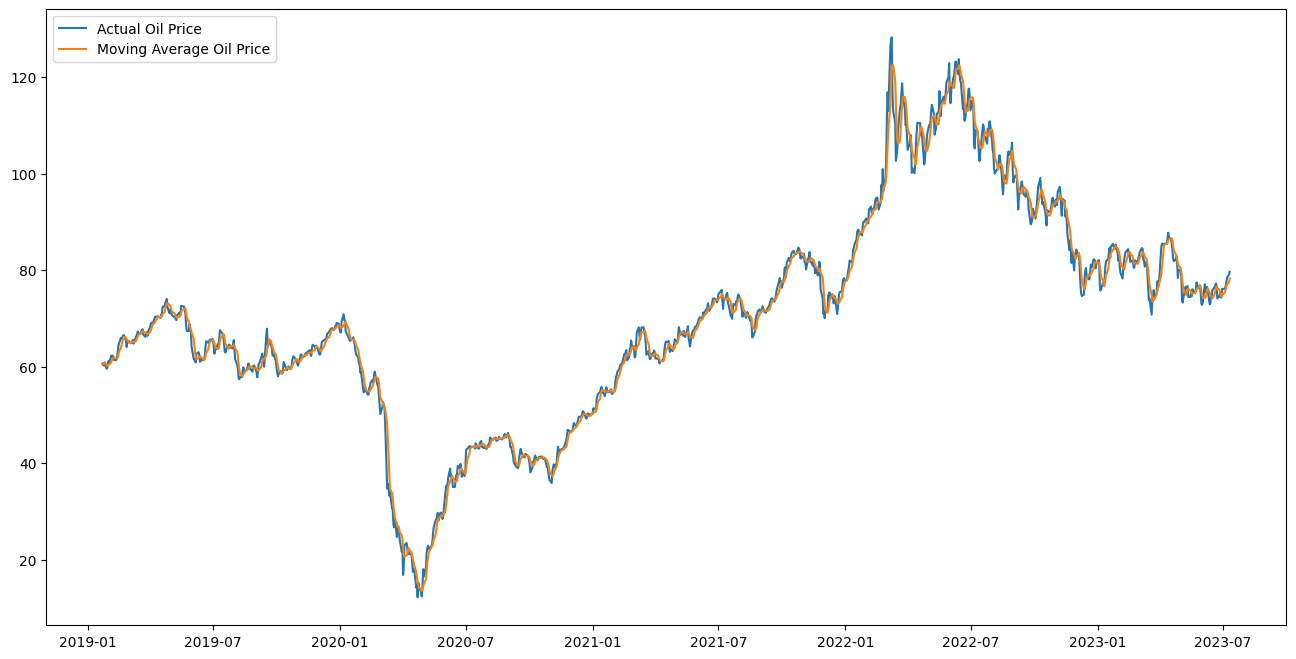

In [44]:
plt.figure(figsize=(16,8))
plt.plot(df_Oil_InUSD['Original_Oil_Price'],label="Actual Oil Price")
plt.plot(df_Oil_InUSD['Original_Oil_Price_MA_5'],label="Moving Average Oil Price")

plt.legend(loc="upper left")

# Finding optimal values of p,d,q for ARIMA

## *   **AR term (p)**
This are lags of dependent variables. e.g. predictors for x(t) is x
(t-1) + x(t-2) + x(t-3).

## *   **Differentiation (d)**
This are number of occasions where we apply differentiation.

## *   **MA term (q)**
This are lags for errors in prediction e.g. predictor for x(t) is e(t-1) + e(t-2) + e(t-3), where e(i) is the difference between the moving average value and the actual value.




In [45]:
from statsmodels.tsa.stattools import adfuller

def perform_adfuller(series):
    # Perform Augmented Dickey-Fuller test
    result = adfuller(series)

    # Extract test statistics and p-value
    test_statistic = result[0]
    p_value = result[1]

    # Print the results
    print("Augmented Dickey-Fuller Test:")
    print(f"Test Statistic: {test_statistic}")
    print(f"P-value: {p_value}")

    # Check the p-value against a significance level (e.g., 0.05) to determine stationarity
    if p_value <= 0.05:
        print("The time series is stationary.")
    else:
        print("The time series is non-stationary.")



#Check if data is stationary by doing differnce

In [46]:
perform_adfuller(df_Oil_InUSD['Original_Oil_Price_MA_15'].diff(1).dropna())

Augmented Dickey-Fuller Test:
Test Statistic: -6.494841789244083
P-value: 1.201446339741276e-08
The time series is stationary.


In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt

def plot_acf_values(data, lags):
    fig, ax = plt.subplots(figsize=(12, 4))
    plot_acf(data.dropna(), lags=lags, ax=ax,zero=False)
    plt.title('ACF')
    plt.show()

def plot_pacf_values(data, lags):
    fig, ax = plt.subplots(figsize=(12, 4))
    plot_pacf(data.dropna(), lags=lags, ax=ax,zero=False,alpha=0.05)
    plt.title('PACF')
    plt.show()


# Verifying the lags which can be selected for Training the model
## The lag value where the chart crosses the confidence interval for the first time can be good starting to point to select values of P(ACF) and Q(PACF)

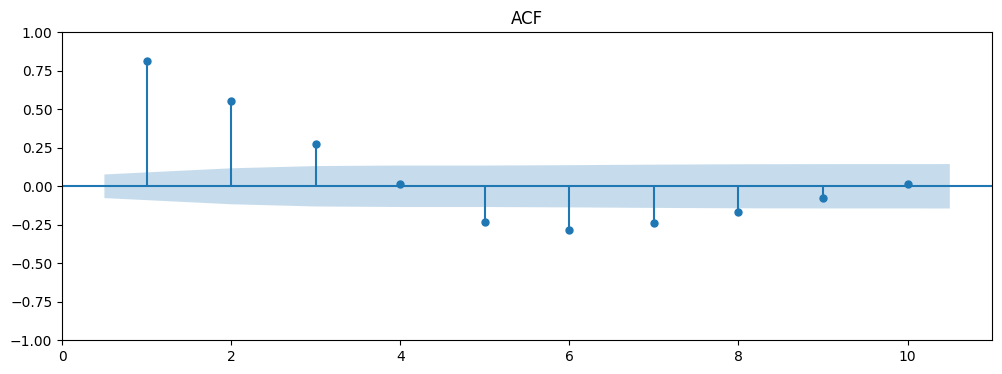

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


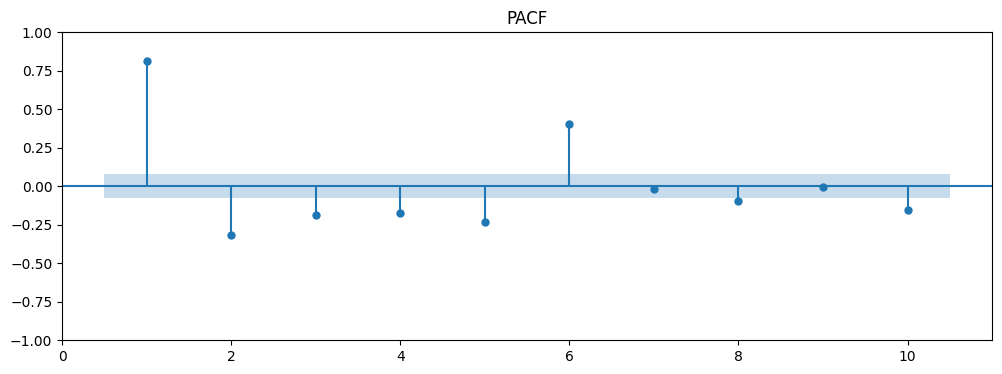

In [13]:
plot_acf_values(df_Oil_InUSD['Original_Oil_Price_MA_5'].diff(1).dropna(),10)
plot_pacf_values(df_Oil_InUSD['Original_Oil_Price_MA_5'].diff(1).dropna(),10)

# Defining Training and Testing timeline

In [14]:
# Define the start and end dates for train and test data
train_start_date = pd.to_datetime(FirstDay)
train_end_date = pd.to_datetime('2022-12-31')
test_start_date = pd.to_datetime('2023-01-01')


In [29]:
train_data_oil = df_Oil_InUSD[(df_Oil_InUSD.index >= train_start_date) & (df_Oil_InUSD.index <= train_end_date)]
test_data_oil = df_Oil_InUSD[df_Oil_InUSD.index >= test_start_date]
train_data_oil.head(5)



,Original_Oil_Price,Original_Oil_Price_MA_5,Original_Oil_Price_MA_10,Original_Oil_Price_MA_15
Date,,,,
2021-01-22,54.69,54.870,55.020,54.254667
2021-01-25,54.85,55.056,55.029,54.488000
2021-01-26,54.87,55.060,54.975,54.762667
2021-01-27,55.31,54.972,54.925,54.897333
2021-01-28,54.36,54.816,54.842,54.932000


In [ ]:
df=train_data_oil

# Auto Arima to find values of p,d,q

In [47]:
from pmdarima import auto_arima
model = auto_arima(train_data_oil['Original_Oil_Price_MA_5'].dropna(),
                         seasonal=False,   # No Seasonality
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=False)
model.summary()


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1387.053, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1038.969, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=787.627, Time=0.46 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=782.677, Time=0.72 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.63 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=1.30 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=844.710, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=807.150, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=795.572, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=761.799, Time=0.61 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.97 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=786.955, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=757.539, Time=0.30 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=753.630, Time=0.44 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : A

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  506
Model:               SARIMAX(5, 1, 0)   Log Likelihood                -358.748
Date:                Wed, 12 Jul 2023   AIC                            731.496
Time:                        18:36:44   BIC                            761.068
Sample:                    01-22-2021   HQIC                           743.095
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0226      0.023      0.993      0.321      -0.022       0.067
ar.L1          0.9407      0.035     27.030      0.000       0.872       1.009
ar.L2         -0.1459      0.042     -3.512      0.000      -0.227      -0.064
ar.L3         -0.0395      0.046     -0.859      0.390      -0.130       0.051
ar.L4          0.0317      0.045      0.705      0.481      -0.056       0.120
ar.L5         -0.2179      0.034     -6.424      0.000      -0.284      -0.151
sigma2         0.2416      0.009     25.816      0.000       0.223       0.260
===================================================================================
Ljung-Box (L1) (Q):                   4.03   Jarque-Bera (JB):               433.08
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               4.57   Skew:                             0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
import warnings
warnings.filterwarnings("ignore")


#After verifying manually diffrent values , along with what was observed from plot_acf and plot_pacf decided values of p,d,q

In [48]:
from statsmodels.tsa.arima.model import ARIMA

oil_model=ARIMA(train_data_oil['Original_Oil_Price_MA_5'],order=(5,1,1))
oil_model_fit=oil_model.fit()
oil_model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                  
===================================================================================
Dep. Variable:     Original_Oil_Price_MA_5   No. Observations:                  506
Model:                      ARIMA(5, 1, 1)   Log Likelihood                -339.671
Date:                     Wed, 12 Jul 2023   AIC                            693.343
Time:                             18:37:30   BIC                            722.915
Sample:                         01-22-2021   HQIC                           704.942
                              - 12-30-2022                                         
Covariance Type:                       opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4722      0.070      6.711      0.000       0.334       0.610
ar.L2          0.2997      0.072      4.185      0.000       0.159       0.440
ar.L3         -0.1174      0.038     -3.103      0.002      -0.192      -0.043
ar.L4          0.1102      0.037      2.979      0.003       0.038       0.183
ar.L5         -0.3827      0.030    -12.819      0.000      -0.441      -0.324
ma.L1          0.5162      0.071      7.290      0.000       0.377       0.655
sigma2         0.2238      0.009     25.436      0.000       0.207       0.241
===================================================================================
Ljung-Box (L1) (Q):                   2.54   Jarque-Bera (JB):               570.61
Prob(Q):                              0.11   Prob(JB):                         0.00
Heteroskedasticity (H):               4.30   Skew:                             0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#Things to verifiy in optimal model selection
### 1) Log Likelihood ==> Higher the log value better the model is performing.
### 2) AIC , BIC, HQIC --> This are information criteria whcih states lower the criteria better is the model.

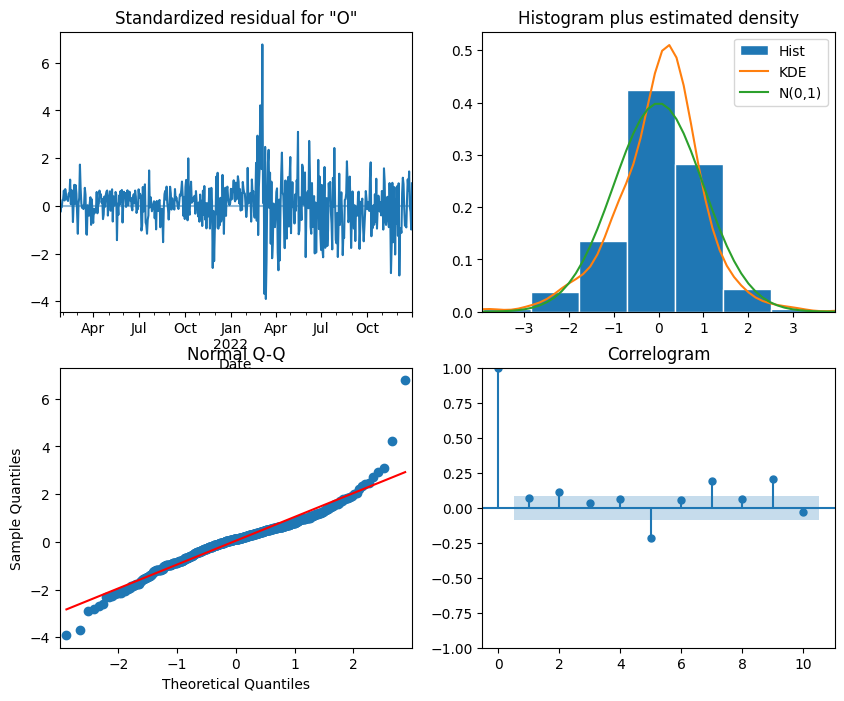

In [50]:
oil_model_fit.plot_diagnostics(figsize=(10,8))
plt.show()


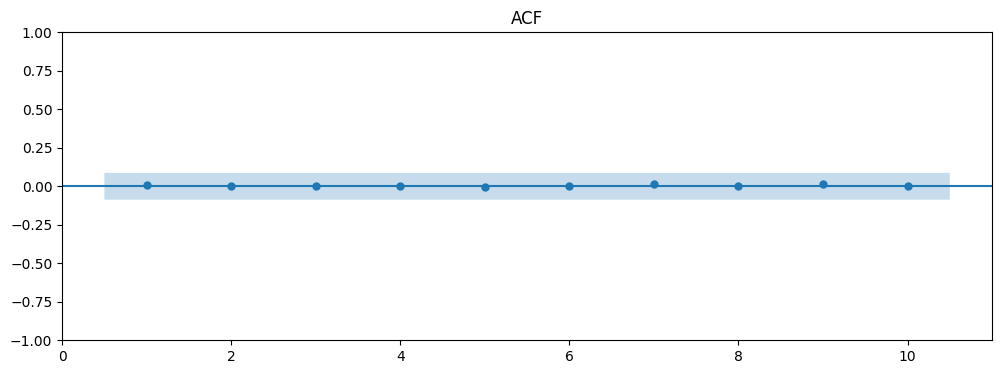

In [49]:
resid=oil_model_fit.resid
plot_acf_values(resid,10)

### **1. Standardized Residulal** : This residual doesnt show any pattern and are randomly distributed around zero.
### **2. Histogram Plust esitmeted density** : Residuals are normally distriuted
### **3. Normal Q-Q Plot** : Most of the are along red line
### **4. Correlogram** : Its and ACF plot of residuals at diffrent lag and their is no autocorrelation seen

In [51]:
# Get in-sample predictions
training_data_predictions = oil_model_fit.get_prediction(start=train_data_oil.dropna().index.min(),
                                                      end=train_data_oil.dropna().index.max(),
                                                      dynamic=False)

train_data_oil[['lower Oil predictions','Higher Oil predictions']] = training_data_predictions.conf_int()

# Create a new column for the predicted values
train_data_oil['Oil predictions'] = training_data_predictions.predicted_mean

train_data_oil

<ipython-input-51-a9cd94b151cd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_oil[['lower Oil predictions','Higher Oil predictions']] = training_data_predictions.conf_int()
<ipython-input-51-a9cd94b151cd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_oil[['lower Oil predictions','Higher Oil predictions']] = training_data_predictions.conf_int()
<ipython-input-51-a9cd94b151cd>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

,Original_Oil_Price,Original_Oil_Price_MA_5,Original_Oil_Price_MA_10,Original_Oil_Price_MA_15,lower Oil predictions,Higher Oil predictions,Oil predictions
Date,,,,,,,
2021-01-22,54.69,54.870,55.020,54.254667,-1959.964864,1959.964864,0.000000
2021-01-25,54.85,55.056,55.029,54.488000,53.013762,56.726318,54.870040
2021-01-26,54.87,55.060,54.975,54.762667,54.123545,56.290501,55.207023
2021-01-27,55.31,54.972,54.925,54.897333,53.980175,56.025661,55.002918
2021-01-28,54.36,54.816,54.842,54.932000,53.842605,55.850119,54.846362
...,...,...,...,...,...,...,...
2022-12-26,82.23,80.288,79.706,78.567333,78.678426,80.532787,79.605606
2022-12-27,82.23,81.108,80.095,78.738667,80.199957,82.054318,81.127137
2022-12-28,81.96,81.628,80.294,79.068667,80.823081,82.677442,81.750261


In [53]:
forecast = oil_model_fit.get_forecast(steps=100 , alpha=0.05)
forecast.predicted_mean

2023-01-02    81.586922
2023-01-03    81.374962
2023-01-04    81.032771
2023-01-05    80.884607
2023-01-06    80.678997
                ...    
2023-05-15    80.903332
2023-05-16    80.903357
2023-05-17    80.903377
2023-05-18    80.903390
2023-05-19    80.903395
Freq: B, Name: predicted_mean, Length: 100, dtype: float64

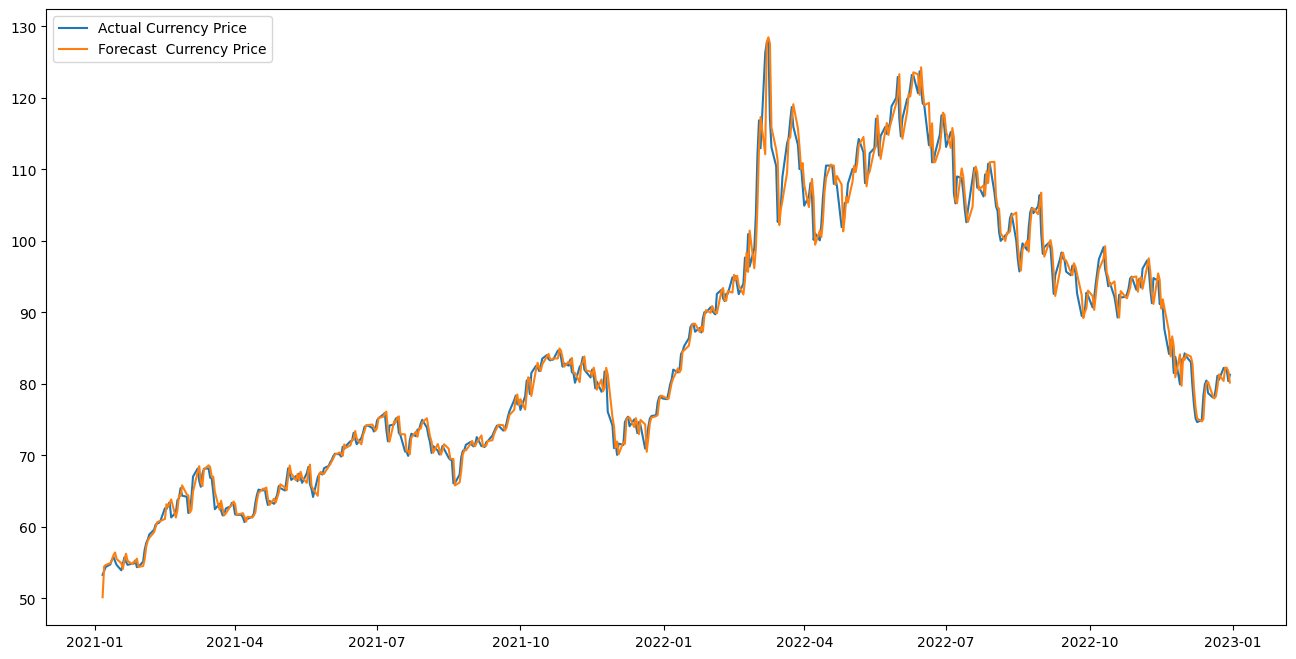

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(train_data_oil['Original_Oil_Price'][2:],label="Actual Currency Price")
plt.plot(train_data_oil['Oil predictions'][2:],label="Forecast  Currency Price")
plt.legend(loc="upper left")

# One Day Steap Ahead -Walk-Forward Validation



In [54]:



# define model configuration
my_order = (1,2,3)

# lists to collect forecasts
forecasts = []

# walk-forward validation
history = [x for x in train_data_oil['Original_Oil_Price']]
for i in range(len(test_data_oil['Original_Oil_Price'])):

    #auto = auto_arima(history, error_action='ignore', suppress_warnings=True)
    #my_order = auto.order
    model = ARIMA(history, order=my_order)
    model_fit = model.fit()
    forecast = model_fit.get_forecast(steps=1, alpha=0.05)
    forecasts.append(forecast.predicted_mean[0])
    history.append(test_data_oil['Original_Oil_Price'][i])

   # print("my_order is {} for date {} and predicted value is {} and actual value is {} ".format(my_order,test_data_oil['Original_Oil_Price'].index[i],forecast.predicted_mean[0],test_data_oil['Original_Oil_Price'][test_data_oil['Original_Oil_Price'].index[i]]))
# Create a dataframe to hold the forecasts with corresponding dates
forecast_df = pd.DataFrame(data={'Forecast': forecasts}, index=test_data_oil['Original_Oil_Price'].index)



KeyboardInterrupt: ignored

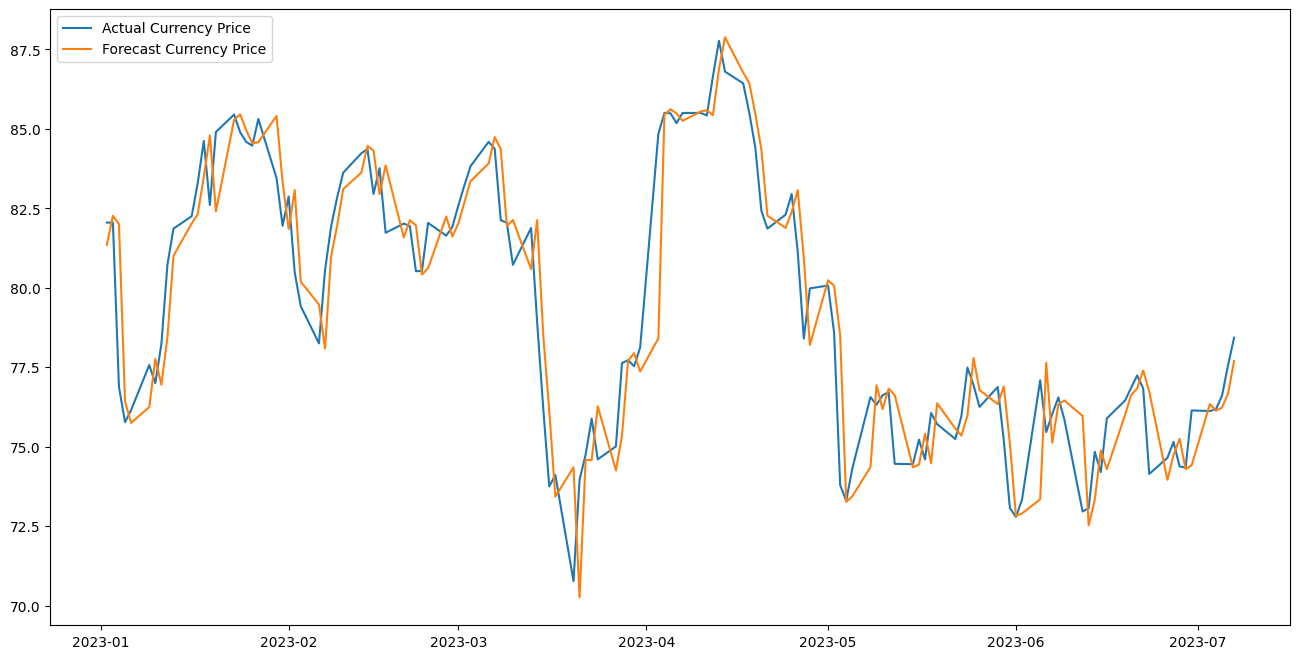

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(test_data_oil['Original_Oil_Price'],label="Actual Currency Price")
plt.plot(forecast_df['Forecast'],label="Forecast Currency Price")

plt.legend(loc="upper left")
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {"Mean Absolute Error": mae, "Mean Squared Error": mse, "Root Mean Squared Error": rmse, "Mean Absolute Percentage Error": mape}




# Calcualate metrics of model for One Day Forecasting

In [ ]:


metrics = calculate_metrics(test_data_oil['Original_Oil_Price'], forecast_df['Forecast'])
metrics

{'Mean Absolute Error': 1.1088037984087675,
 'Mean Squared Error': 2.373507771546103,
 'Root Mean Squared Error': 1.5406192818299085,
 'Mean Absolute Percentage Error': 1.4130556590810637}

# Five Day Steap Ahead -Walk-Forward Validation



In [ ]:
import pandas as pd


# define model configuration
my_order = (1,2,3)

# lists to collect forecasts
forecasts = []

# walk-forward validation
history = [x for x in train_data_oil['Original_Oil_Price']]
for i in range(0, len(test_data_oil['Original_Oil_Price']), 5):  # now stepping by 5
    # Commenting below lines a model not predicting any new model , so used the value found earlier
    #auto = auto_arima(history, error_action='ignore', suppress_warnings=True)
    #my_order = auto.order

    model = ARIMA(history, order=my_order)
    model_fit = model.fit()

    # if less than 5 steps remaining, adjust steps to fit
    steps = min(5, len(test_data_oil['Original_Oil_Price']) - i)

    forecast = model_fit.get_forecast(steps=steps, alpha=0.05)

    forecasts.extend(forecast.predicted_mean)  # using extend instead of append

    # Append all forecasted values to the history
    history.extend(test_data_oil['Original_Oil_Price'][i:i+steps])
    print("my_order is {} for Week Starting {} and predicted value is {} and actual value is {}".format(my_order,test_data_oil['Original_Oil_Price'].index[i],forecast.predicted_mean,test_data_oil['Original_Oil_Price'][test_data_oil['Original_Oil_Price'].index[i:i+steps]].values.tolist()))
# Create a dataframe to hold the forecasts with corresponding dates
forecast_df = pd.DataFrame(data={'Forecast': forecasts}, index=test_data_oil['Original_Oil_Price'].index)


my_order is (1, 2, 3) for Week Starting 2023-01-02 00:00:00 and predicted value is [81.35179059 81.48376433 81.47004432 81.5929899  81.5877386 ] and actual value is [82.05, 82.05, 76.88, 75.77, 76.15]
my_order is (1, 2, 3) for Week Starting 2023-01-09 00:00:00 and predicted value is [76.24584281 76.28268385 76.3378579  76.37579412 76.4299384 ] and actual value is [77.57, 77.0, 78.23, 80.73, 81.86]
my_order is (1, 2, 3) for Week Starting 2023-01-16 00:00:00 and predicted value is [82.02035803 82.06084662 82.13389219 82.17624497 82.2475331 ] and actual value is [82.25, 83.3, 84.62, 82.6, 84.9]
my_order is (1, 2, 3) for Week Starting 2023-01-23 00:00:00 and predicted value is [85.2866551  85.2709621  85.40724284 85.40097314 85.52841488] and actual value is [85.45, 84.89, 84.59, 84.47, 85.31]
my_order is (1, 2, 3) for Week Starting 2023-01-30 00:00:00 and predicted value is [85.40464825 85.50321752 85.53178198 85.6260381  85.65864997] and actual value is [83.45, 81.95, 82.87, 80.48, 79.42]

# Calcualate metrics of model for Five  Day Forecasting

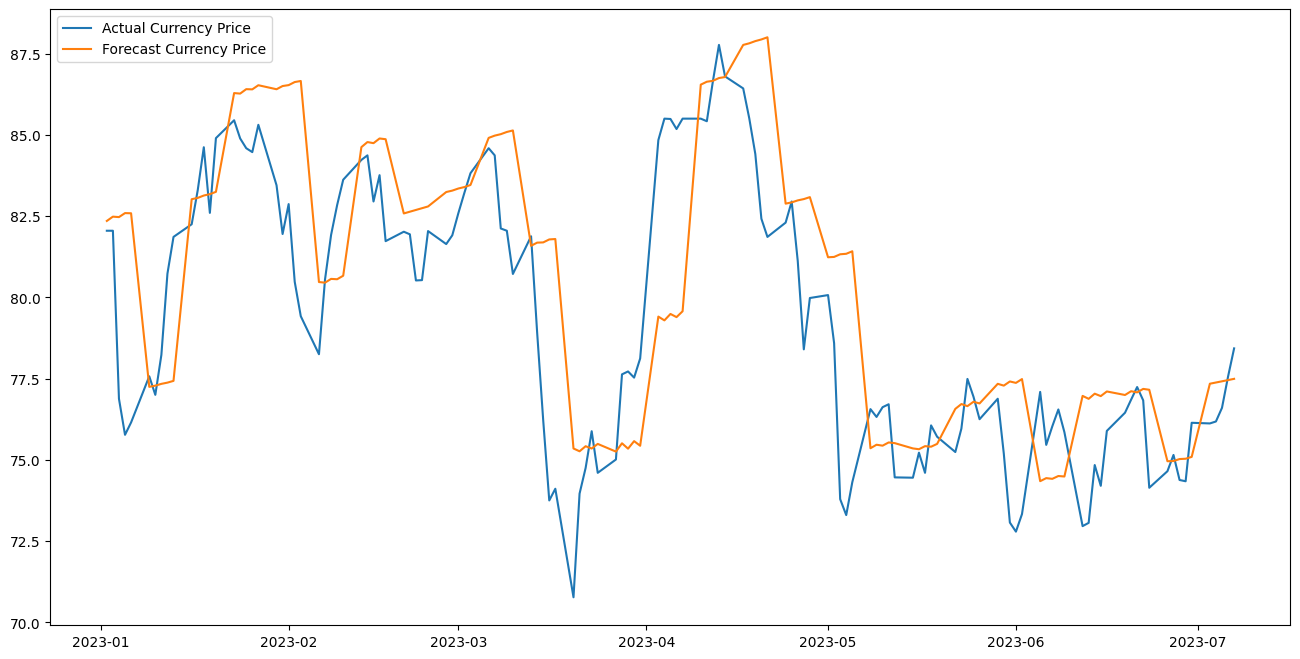

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(test_data_oil['Original_Oil_Price'],label="Actual Currency Price")
plt.plot(forecast_df['Forecast']+1,label="Forecast Currency Price")

plt.legend(loc="upper left")
plt.show()


In [ ]:


metrics = calculate_metrics(test_data_oil['Original_Oil_Price'], forecast_df['Forecast'])
metrics

{'Mean Absolute Error': 2.063890496022513,
 'Mean Squared Error': 8.019850564659363,
 'Root Mean Squared Error': 2.8319340678517504,
 'Mean Absolute Percentage Error': 2.6188076211687847}